In [1]:
using Revise
includet("utils/file_reader.jl")
includet("utils/some_data.jl")
includet("utils/utils_graph.jl")
includet("resolution/compact/compact_formulation.jl")
includet("resolution/path/path_generation.jl")
using Revise, JuMP, CPLEX



In [2]:
instance = get_instance_from_folder("instances/realistic/2806/easyone/")


InstanceVNE(Any[Meta graph based on a SimpleDiGraph{Int64} with vertex labels of type Int64, vertex metadata of type Dict, edge metadata of type Dict, graph metadata given by Dict(:type => "virtual", :name => "wheel_3"), and default weight 1.0], Meta graph based on a SimpleDiGraph{Int64} with vertex labels of type Int64, vertex metadata of type Dict, edge metadata of type Dict, graph metadata given by Dict(:type => "substrate", :name => "zoo_Xeex"), and default weight 1.0)

In [3]:
# Marche juste pour un réseau virtuel héing
central_s_node = argmax(betweenness_centrality(instance.s_network))
central_v_nodes = Dict() 
for v_network in instance.v_networks
    central_v_nodes[v_network] = argmax(betweenness_centrality(v_network))
end

In [4]:
shortest_path_substrate = get_shortest_paths(instance.s_network, 1);
shortest_path_virtuals = Dict()
for v_network in instance.v_networks
    shortest_path_virtuals[v_network] = get_shortest_paths(v_network, 1)
end

In [5]:
penalty_substrate = []
for s_node in vertices(instance.s_network)
    shortest_path = shortest_path_substrate[(central_s_node, s_node)]
    if length(shortest_path)>0
        push!(penalty_substrate, shortest_path[1].cost)
    else
        push!(penalty_substrate, 9999) #it should not happen, but so far it does
    end
end

distance_virtuals = Dict()
for v_network in instance.v_networks
    distance_virtual = []
    for v_node in vertices(v_network)
        shortest_path = shortest_path_substrate[(central_v_nodes[v_network], v_node)]
        if length(shortest_path)>0
            if shortest_path[1].cost == 0
                push!(distance_virtual, 1)
            else
                push!(distance_virtual, shortest_path[1].cost)
            end
        else
            push!(distance_virtual, 1) #it should not happen, but so far it does
        end
    end
    distance_virtuals[v_network] = distance_virtual
end

In [6]:
print(distance_virtuals[instance.v_networks[1]])

Any[1, 1, 2, 3]

In [7]:
#### Model
model_placement = Model(CPLEX.Optimizer)
set_attribute(model_placement, "CPX_PARAM_EPINT", 1e-8)

### Variables
x_variables = @variable(model_placement, x[v_network in instance.v_networks, vertices(v_network), vertices(instance.s_network)], binary=true);

### Objective
placement_cost = @expression(model_placement, sum( 
    instance.s_network[s_node][:cost] * v_network[v_node][:dem] * x[v_network, v_node, s_node] 
    for v_network in instance.v_networks for v_node in vertices(v_network) for s_node in vertices(instance.s_network) ))
@objective(model_placement, Min, placement_cost);

### Constraints

# one substrate node per virtual node
for v_network in instance.v_networks
    for v_node in vertices(v_network)
        @constraint(model_placement, sum(x[v_network, v_node, s_node] for s_node in vertices(instance.s_network)) == 1)
    end
end

# node capacity
for s_node in vertices(instance.s_network)
    @constraint(model_placement, 
        sum( v_network[v_node][:dem] * x[v_network, v_node, s_node] 
            for v_network in instance.v_networks for v_node in vertices(v_network) ) 
        <= 
        instance.s_network[s_node][:cap] )
end

# Solving
set_time_limit_sec(model_placement, 30.)
optimize!(model_placement)

# Get the solution
x_values = value.(x_variables);
node_placements = []
for v_network in instance.v_networks
    node_placement = []
    for v_node in vertices(v_network)
        current_placement = []
        for s_node in vertices(instance.s_network)
            if x_values[v_network, v_node, s_node] > 0.99
                push!(current_placement, 1)
            else
                push!(current_placement, 0)
            end
        end
        push!(node_placement, current_placement)
    end
    push!(node_placements, node_placement)
end


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               30
CPXPARAM_MIP_Tolerances_Integrality              1e-08
Found incumbent of value 4.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 28 rows, 96 columns, and 192 nonzeros.
Reduced MIP has 96 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.12 ticks)
Probing time = 0.00 sec. (0.12 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 28 rows, 96 columns, and 192 nonzeros.
Reduced MIP has 96 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.19 ticks)
Probing time = 0.00 sec. (0.12 ticks)
Clique table members: 28.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.05 ticks)

        Nodes                                         Cuts/
   Node  Left     Object

In [8]:
for i_v_network in 1:length(instance.v_networks)
    println("Virtual network n" * string(i_v_network))
    for v_node in vertices(instance.v_networks[i_v_network])
        for s_node in vertices(instance.s_network)
            if node_placements[i_v_network][v_node][s_node] > 0.99
                println(string(v_node) * " => " * string(s_node))
            end
        end
    end
end

Virtual network n1
1 => 1
2 => 2
3 => 3
4 => 4


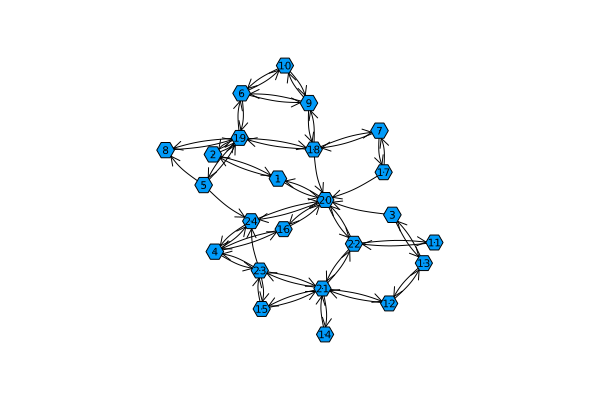

In [9]:
includet("utils/visu.jl")
visu_graph(instance.s_network)

In [10]:
print("Constructing compact model...")

#### Model
model_routing = Model(CPLEX.Optimizer)
set_attribute(model_routing, "CPX_PARAM_EPINT", 1e-8)

### Variables
y_variables = @variable(model_routing, y[v_network in instance.v_networks, edges(v_network), edges(instance.s_network)], binary=true);

### Objective
routing_cost = @expression(model_routing, sum( instance.s_network[src(s_edge), dst(s_edge)][:cost] * v_network[src(v_edge), dst(v_edge)][:dem] * y[v_network, v_edge, s_edge] 
    for v_network in instance.v_networks for v_edge in edges(v_network) for s_edge in edges(instance.s_network) ))
@objective(model_routing, Min, routing_cost);


### Constraints
# edge capacity
for s_edge in edges(instance.s_network)
    @constraint(model_routing, 
        sum( v_network[src(v_edge), dst(v_edge)][:dem] * y[v_network, v_edge, s_edge] 
            for v_network in instance.v_networks for v_edge in edges(v_network)) 
        <= 
        instance.s_network[src(s_edge), dst(s_edge)][:cap] )
end

# Flow conservation
for s_node in vertices(instance.s_network)
    for i_v_network in 1:length(instance.v_networks)
        v_network = instance.v_networks[i_v_network]
        for v_edge in edges(v_network)
            @constraint(model_routing, 
            node_placements[i_v_network][src(v_edge)][s_node] - node_placements[i_v_network][dst(v_edge)][s_node] 
                ==
                sum(y[v_network, v_edge, s_edge] for s_edge in get_out_edges(instance.s_network, s_node)) - 
                    sum(y[v_network, v_edge, s_edge] for s_edge in get_in_edges(instance.s_network, s_node))
            )
        end
    end
end

set_time_limit_sec(model_routing, 30.)
optimize!(model_routing)


Constructing compact model...Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               30
CPXPARAM_MIP_Tolerances_Integrality              1e-08
Tried aggregator 2 times.
MIP Presolve eliminated 10 rows and 32 columns.
Aggregator did 18 substitutions.
Reduced MIP has 250 rows, 508 columns, and 1524 nonzeros.
Reduced MIP has 508 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.83 ticks)
Found incumbent of value 30.000000 after 0.00 sec. (3.43 ticks)
Probing time = 0.00 sec. (0.15 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 250 rows, 508 columns, and 1524 nonzeros.
Reduced MIP has 508 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.88 ticks)
Probing time = 0.00 sec. (0.15 ticks)
Clique table members: 114.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation sol

In [12]:
solve_compact_integer(instance, false, false)

Constructing compact model...Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               30
CPXPARAM_MIP_Tolerances_Integrality              1e-08
Tried aggregator 1 time.
Reduced MIP has 306 rows, 654 columns, and 2298 nonzeros.
Reduced MIP has 654 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.03 ticks)
Found incumbent of value 33.000000 after 0.00 sec. (3.57 ticks)
Probing time = 0.00 sec. (0.51 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 306 rows, 654 columns, and 2298 nonzeros.
Reduced MIP has 654 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.51 ticks)
Probing time = 0.00 sec. (0.51 ticks)
Clique table members: 91.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.60 ticks)

        Nodes                                 

1-element Vector{Any}:
 Node placement of cost :4
       1 => 4
       2 => 23
       3 => 24
       4 => 16
Edge routing of cost: 11
       Edge 1 => 2 => Path(4, 23, Any[Edge 4 => 23], 1)
       Edge 1 => 3 => Path(4, 24, Any[Edge 4 => 24], 1)
       Edge 1 => 4 => Path(4, 16, Any[Edge 4 => 16], 1)
       Edge 2 => 1 => Path(23, 4, Any[Edge 23 => 4], 1)
       Edge 2 => 3 => Path(23, 24, Any[Edge 23 => 24], 1)
       Edge 3 => 1 => Path(24, 4, Any[Edge 24 => 4], 1)
       Edge 3 => 4 => Path(24, 16, Any[Edge 24 => 4, Edge 4 => 16], 2)
       Edge 4 => 1 => Path(16, 4, Any[Edge 16 => 4], 1)
       Edge 4 => 2 => Path(16, 23, Any[Edge 16 => 4, Edge 4 => 23], 2)
